# Exploration of the effect of aleatoric uncertainties on Sobol Coefficients

In this notebook we will explore the role od aleatoric uncertainties on the calculation od statistical quantities such as Sobol Coefficients.

To do this we take the results of an existing run using the fusion tutorial model and then perturb the "measured" values at the various positions determined by the PCE campaign, and recalculate the Sobol indices.  We do this for a number of cases and explore the impact of the chosen noise level on the calculated Sobol indices.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import easyvvuq as uq
import os
import ast
import time
import pandas as pd

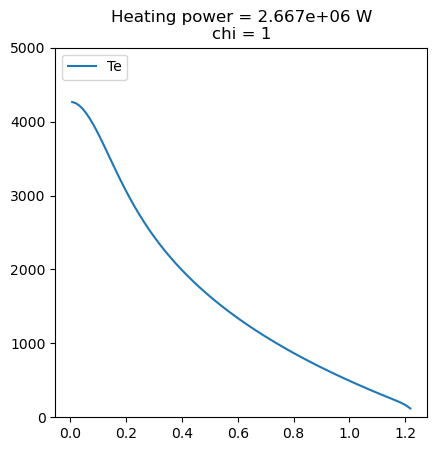

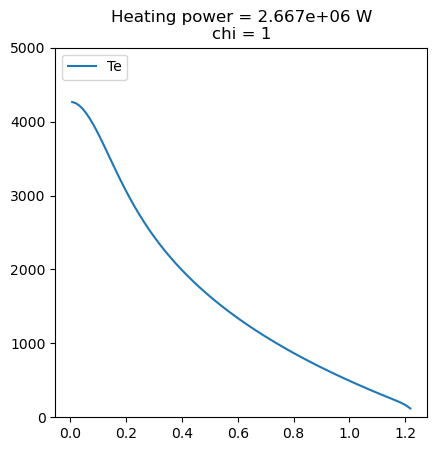

In [2]:
# This tutorial builds on the fusion example
import fusion
Te, ne, rho, rho_norm = fusion.solve_Te()

In [3]:
# initialize the random number generator
rng = np.random.default_rng()

In [4]:
# function that will be used to add correlated noise
def randomize(x, ng=11, lcorr=0.2):
  y = 0.0
  for x0, r in zip(np.linspace(0,1,ng), rng.standard_normal(ng)):
    y += np.exp(-((x-x0)/lcorr)**2)*r
  return y

Text(0.5, 1.0, 'Based on 1000 samples')

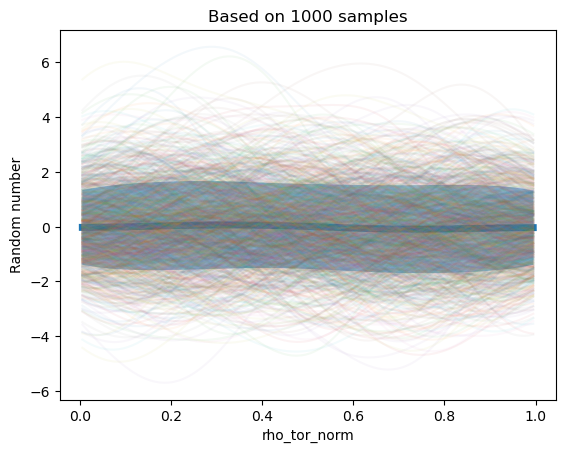

In [5]:
# Demonstrate how the randomize function works
Randomize = np.array([randomize(rho_norm) for i in range(1000)])
plt.clf()
plt.plot(rho_norm, Randomize.mean(axis=0), lw=5)
plt.fill_between(rho_norm, Randomize.mean(axis=0)-Randomize.std(axis=0), Randomize.mean(axis=0)+Randomize.std(axis=0), alpha=0.5)
plt.plot(rho_norm, Randomize.T, alpha=0.05)
plt.xlabel('rho_tor_norm')
plt.ylabel('Random number')
plt.title('Based on 1000 samples')

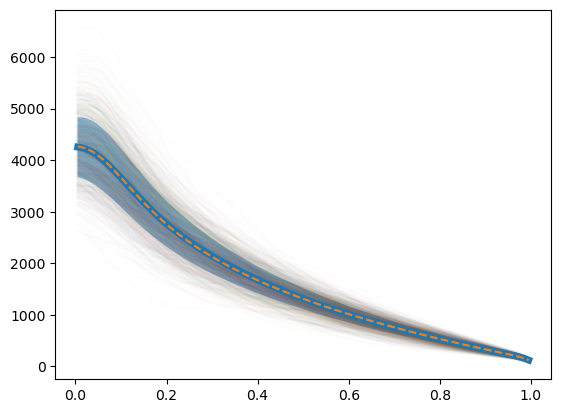

In [6]:
# Show what 10% noise applied to the Te profile looks like
Te_scan = np.array([Te+Te/10*randomize(rho_norm) for i in range(1000)])
Te_scan = Te*(1+0.1*Randomize)

plt.clf()
plt.plot(rho_norm, Te_scan.T, alpha=0.01)
plt.plot(rho_norm, Te_scan.mean(axis=0), lw=5)
plt.fill_between(rho_norm, Te_scan.mean(axis=0)-Te_scan.std(axis=0), Te_scan.mean(axis=0)+Te_scan.std(axis=0), alpha=0.5)
plt.plot(rho_norm, Te, '--')

Running locally
<Client: 'tcp://127.0.0.1:57592' processes=8 threads=8, memory=16.00 GiB>
Time for phase 1 = 9.115
Number of samples = 243
Time for phase 2 = 0.337
Volume = 88.8264396098042 m^3
Heating power = 1.845e+06 W
Volume = 88.8264396098042 m^3
Heating power = 1.845e+06 W
Volume = 88.8264396098042 m^3
Heating power = 1.845e+06 W
Volume = 88.8264396098042 m^3
Heating power = 1.845e+06 W
Volume = 88.8264396098042 m^3
Heating power = 1.845e+06 W
Volume = 88.8264396098042 m^3
Heating power = 1.845e+06 W
Volume = 88.8264396098042 m^3
Heating power = 1.845e+06 W
Volume = 88.8264396098042 m^3
Heating power = 1.845e+06 W
Volume = 88.8264396098042 m^3
Heating power = 1.845e+06 W
Volume = 88.8264396098042 m^3
Heating power = 1.845e+06 W
Volume = 88.8264396098042 m^3
Heating power = 1.845e+06 W
Volume = 88.8264396098042 m^3
Heating power = 1.845e+06 W
Volume = 88.8264396098042 m^3
Heating power = 1.845e+06 W
Volume = 88.8264396098042 m^3
Heating power = 1.845e+06 W
Volume = 88.826439609804

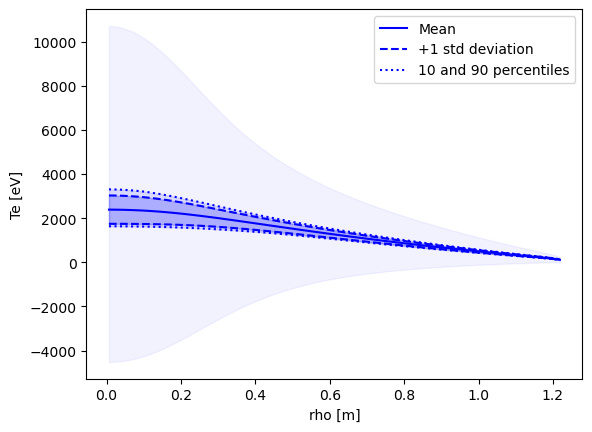

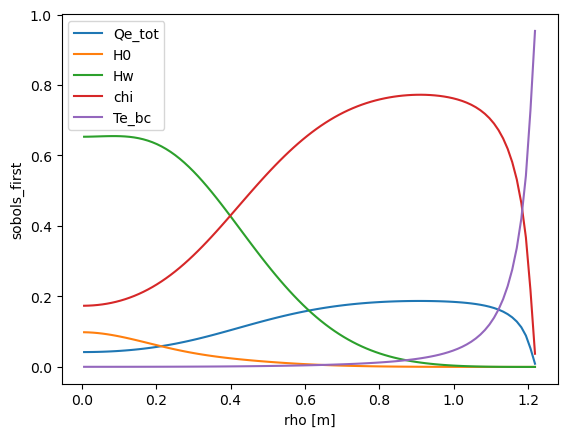

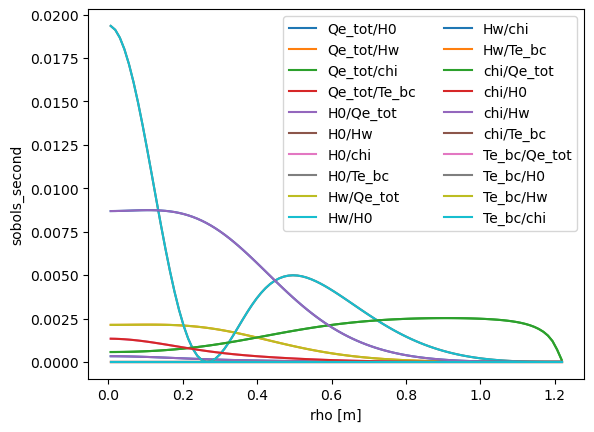

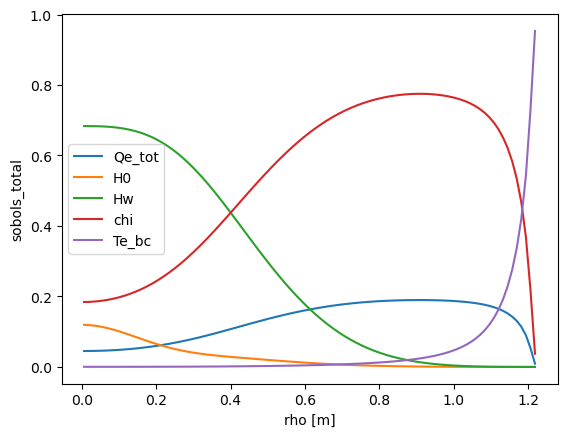

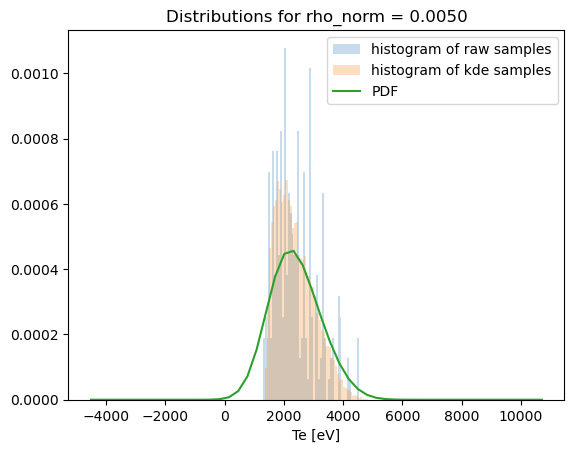

In [7]:
# Now run an EasyVVUQ campaign
%run ./easyvvuq_fusion_dask_tutorial.py -l

In [8]:
# We grab the saved results
results = pickle.load(open('easyvvuq_fusion_dask_tutorial/fusion_results.pickle', 'rb'))

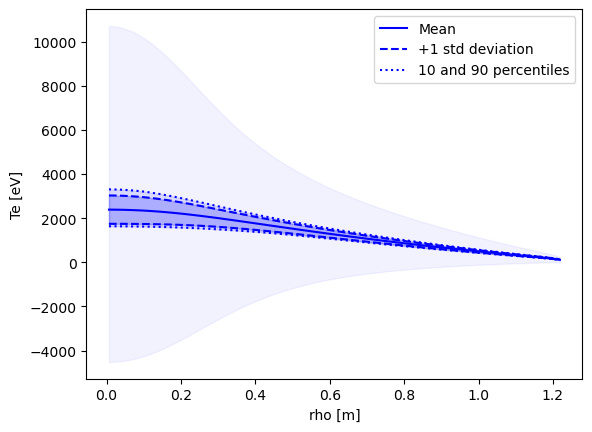

In [9]:
# And plot some results
rho_norm = results.describe("rho_norm", "mean")
te_mean = results.describe("te", "mean")
te_std = results.describe("te", "std")
te_10_pct = results.describe("te", "10%")
te_90_pct = results.describe("te", "90%")
te_min = results.describe("te", "min")
te_max = results.describe("te", "max")

plt.figure()
plt.plot(rho, te_mean, "b-", label="Mean")
plt.plot(rho, te_mean - te_std, "b--", label="+1 std deviation")
plt.plot(rho, te_mean + te_std, "b--")
plt.fill_between(rho, te_mean - te_std, te_mean + te_std,
                 color="b", alpha=0.2)
plt.plot(rho, te_10_pct, "b:", label="10 and 90 percentiles")
plt.plot(rho, te_90_pct, "b:")
plt.fill_between(rho, te_10_pct, te_90_pct, color="b", alpha=0.1)
plt.fill_between(rho, te_min, te_max, color="b", alpha=0.05)

plt.legend(loc=0)
plt.xlabel("rho [m]")
plt.ylabel("Te [eV]");

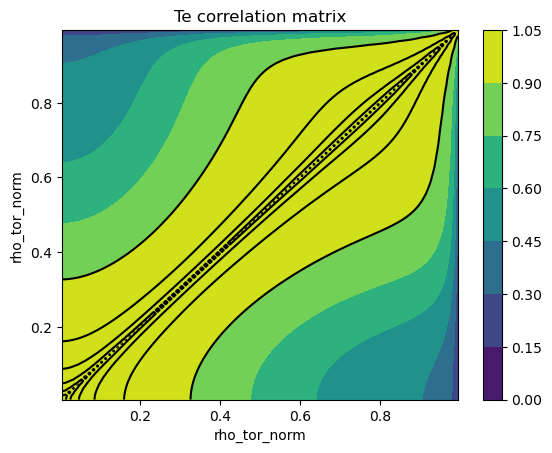

In [10]:
plt.clf()
plt.contourf(rho_norm, rho_norm, results.raw_data['correlation_matrices']['te'])
plt.colorbar()
plt.xlabel('rho_tor_norm')
plt.ylabel('rho_tor_norm')
plt.title('Te correlation matrix')
plt.contour(rho_norm, rho_norm, results.raw_data['correlation_matrices']['te'], levels=[0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999], colors='k');

In [11]:
# We recover the old campaign
DIR = 'easyvvuq_fusion_dask_tutorial'
old_campaign = uq.Campaign(name="fusion_pce.", db_location= f'sqlite:///{os.path.abspath(os.curdir)}/{DIR}/campaign.db')
old_runs = old_campaign.list_runs()

results_df = old_campaign.get_collation_result()

In [12]:
# Define a function for perturbing an old result
def get_case(old_runs, noise=0.1):

  new_runs = []
  for r in old_runs:
    d = r[1].copy()
    d['run_id'] = r[0]
    res = ast.literal_eval(d['result'])
    res['te'] = list(np.array(res['te']) * (1+noise*randomize(np.array(res['rho_norm']))))
    d['result'] = res
    new_runs.append(d)

  df_runs=[]
  for d in new_runs:
    D = {**d['params'], **d['result']}
    D['run_name'] = d['run_name']
    D['run_dir'] = d['run_dir']
    D['run_id'] = d['run_id']
    pd_result={}
    for key in D.keys():
      if not isinstance(D[key], list):
        try:
          pd_result[(key, 0)].append(D[key])
        except KeyError:
          pd_result[(key, 0)] = D[key]
      else:
        for i, elt in enumerate(D[key]):
          try:
            pd_result[(key, i)].append(D[key][i])[0]
          except KeyError:
            pd_result[(key, i)] = [D[key][i]][0]
    df_runs.append(pd_result)

  df = pd.DataFrame(df_runs)
  df.columns = pd.MultiIndex.from_tuples(df.columns)
  return df

In [13]:
# See if we recover the old results with zero noise
df = get_case(old_runs, noise=0.0)
# Here we create an analysis instance based on the sampler from the old campaign
analysis = uq.analysis.PCEAnalysis(sampler=old_campaign.get_active_sampler(), qoi_cols=results.qois)
# And use this to perform the PCE analysis based on the just created dataframe 
R = analysis.analyse(df)

In [14]:
# Compare the mean of te
results.describe('te', 'mean') - R.describe('te', 'mean')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [15]:
# Compare the te ifirst sobol for Qe_tot
results.raw_data['sobols_first']['te']['Qe_tot'] - R.raw_data['sobols_first']['te']['Qe_tot']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

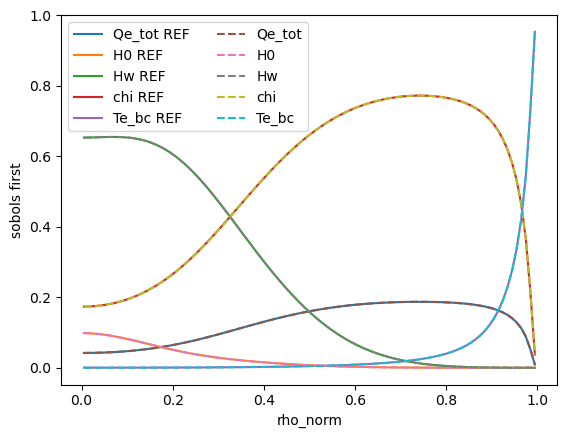

In [16]:
# Compare (graphically) the Sobol first results: stabndard and with zero noise
rho_norm = results.describe('rho_norm', 'mean')

plt.clf()
for s in results.sobols_first('te').keys():
  plt.plot(rho_norm, results.sobols_first('te')[s], '-', label=f'{s} REF')

for s in R.sobols_first('te').keys():
  plt.plot(rho_norm, R.sobols_first('te')[s], '--', label=s)

plt.xlabel('rho_norm')
plt.ylabel('sobols first')
plt.legend(loc=0, ncol=2)

In [17]:
# Now perform a campaign over four noise levels with 100 samples each
# We will also restrict the analysis to just 'te' and switch off the calculation/saving of CorrelationMatrices and CorrelationMatrices
analysis = uq.analysis.PCEAnalysis(sampler=old_campaign.get_active_sampler(), qoi_cols=['te'], CorrelationMatrices=False, OutputDistributions=False)
N = 4 * 100
time_start = time.time()
icnt = 0
collect_results={}
for noise in [0.01, 0.02, 0.05, 0.10]:
  print(f'{noise = }')
  collect_results[noise] = []
  for i in range(100):
    print(f'{i = }')
    df = get_case(old_runs, noise=noise)
    R = analysis.analyse(df)
    collect_results[noise].append({'df': df, 'R': R})
    icnt += 1
    print(f'Expected remaining time = {(time.time() - time_start)/icnt*(N-icnt):0.3f}')
time_end = time.time()
print(f'Elapsed time was {time_end-time_start:0.3f} seconds')

noise = 0.01
i = 0


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 523.804
i = 1


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 512.761
i = 2


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 517.725
i = 3


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 525.853
i = 4


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 521.626
i = 5


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 537.664
i = 6


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 541.288
i = 7


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 542.135
i = 8


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 537.483
i = 9


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 535.795
i = 10


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 530.801
i = 11


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 530.119
i = 12


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 528.910
i = 13


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 526.084
i = 14


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 522.177
i = 15


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 518.935
i = 16


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 516.479
i = 17


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 518.418
i = 18


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 516.187
i = 19


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 515.655
i = 20


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 513.973
i = 21


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 512.072
i = 22


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 509.565
i = 23


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 507.948
i = 24


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 518.050
i = 25


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 517.703
i = 26


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 516.303
i = 27


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 514.141
i = 28


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 516.056
i = 29


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 514.429
i = 30


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 514.206
i = 31


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 511.338
i = 32


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 508.486
i = 33


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 505.979
i = 34


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 503.444
i = 35


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 503.981
i = 36


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 502.220
i = 37


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 503.446
i = 38


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 501.199
i = 39


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 498.976
i = 40


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 497.503
i = 41


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 495.600
i = 42


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 493.719
i = 43


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 494.126
i = 44


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 492.947
i = 45


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 491.403
i = 46


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 490.314
i = 47


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 488.461
i = 48


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 487.030
i = 49


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 485.400
i = 50


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 488.884
i = 51


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 488.238
i = 52


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 486.171
i = 53


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 486.474
i = 54


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 485.311
i = 55


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 484.098
i = 56


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 484.017
i = 57


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 481.985
i = 58


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 479.749
i = 59


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 477.598
i = 60


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 475.672
i = 61


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 473.684
i = 62


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 471.804
i = 63


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 470.220
i = 64


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 468.290
i = 65


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 466.319
i = 66


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 464.172
i = 67


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 462.460
i = 68


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 460.442
i = 69


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 459.440
i = 70


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 457.682
i = 71


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 455.672
i = 72


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 454.150
i = 73


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 452.138
i = 74


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 450.138
i = 75


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 448.204
i = 76


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 446.257
i = 77


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 444.305
i = 78


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 442.499
i = 79


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 440.591
i = 80


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 438.694
i = 81


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 436.872
i = 82


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 435.094
i = 83


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 434.080
i = 84


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 432.379
i = 85


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 431.057
i = 86


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 429.468
i = 87


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 428.022
i = 88


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 426.410
i = 89


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 424.612
i = 90


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 423.113
i = 91


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 421.608
i = 92


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 419.941
i = 93


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 420.044
i = 94


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 419.000
i = 95


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 417.818
i = 96


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 416.700
i = 97


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 415.903
i = 98


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 414.773
i = 99


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 413.458
noise = 0.02
i = 0


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 411.809
i = 1


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 410.050
i = 2


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 408.388
i = 3


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 406.731
i = 4


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 405.297
i = 5


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 403.870
i = 6


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 402.448
i = 7


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 400.997
i = 8


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 399.466
i = 9


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 397.974
i = 10


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 396.361
i = 11


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 395.223
i = 12


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 393.474
i = 13


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 391.797
i = 14


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 390.114
i = 15


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 388.435
i = 16


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 386.817
i = 17


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 385.344
i = 18


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 383.668
i = 19


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 382.077
i = 20


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 380.440
i = 21


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 378.788
i = 22


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 377.373
i = 23


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 375.837
i = 24


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 374.740
i = 25


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 373.144
i = 26


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 371.548
i = 27


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 370.051
i = 28


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 368.607
i = 29


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 367.262
i = 30


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 365.812
i = 31


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 364.449
i = 32


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 363.438
i = 33


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 362.485
i = 34


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 361.305
i = 35


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 360.494
i = 36


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 359.579
i = 37


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 358.290
i = 38


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 356.806
i = 39


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 355.705
i = 40


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 354.314
i = 41


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 352.993
i = 42


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 351.634
i = 43


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 350.159
i = 44


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 348.649
i = 45


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 347.192
i = 46


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 345.677
i = 47


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 344.104
i = 48


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 342.572
i = 49


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 341.106
i = 50


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 339.582
i = 51


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 338.021
i = 52


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 336.482
i = 53


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 335.322
i = 54


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 333.797
i = 55


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 332.262
i = 56


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 331.284
i = 57


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 329.847
i = 58


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 328.284
i = 59


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 326.747
i = 60


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 325.209
i = 61


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 323.692
i = 62


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 322.173
i = 63


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 320.672
i = 64


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 319.172
i = 65


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 317.700
i = 66


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 316.265
i = 67


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 315.242
i = 68


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 313.806
i = 69


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 312.358
i = 70


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 310.890
i = 71


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 309.383
i = 72


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 307.886
i = 73


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 306.975
i = 74


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 305.547
i = 75


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 304.044
i = 76


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 302.660
i = 77


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 301.420
i = 78


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 300.362
i = 79


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 298.929
i = 80


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 298.079
i = 81


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 296.676
i = 82


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 296.352
i = 83


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 295.036
i = 84


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 294.178
i = 85


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 292.886
i = 86


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 291.489
i = 87


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 290.037
i = 88


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 288.575
i = 89


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 287.233
i = 90


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 285.753
i = 91


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 284.334
i = 92


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 282.948
i = 93


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 281.506
i = 94


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 280.067
i = 95


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 278.603
i = 96


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 277.478
i = 97


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 276.136
i = 98


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 274.712
i = 99


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 273.311
noise = 0.05
i = 0


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 271.882
i = 1


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 270.495
i = 2


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 269.050
i = 3


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 267.657
i = 4


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 266.217
i = 5


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 264.801
i = 6


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 263.410
i = 7


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 261.954
i = 8


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 260.563
i = 9


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 259.143
i = 10


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 257.744
i = 11


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 256.340
i = 12


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 255.119
i = 13


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 253.672
i = 14


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 252.263
i = 15


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 250.839
i = 16


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 249.386
i = 17


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 247.938
i = 18


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 246.494
i = 19


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 245.059
i = 20


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 243.632
i = 21


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 242.203
i = 22


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 240.776
i = 23


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 239.334
i = 24


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 237.980
i = 25


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 236.882
i = 26


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 235.531
i = 27


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 234.299
i = 28


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 232.878
i = 29


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 231.456
i = 30


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 230.074
i = 31


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 228.632
i = 32


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 227.217
i = 33


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 225.811
i = 34


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 224.387
i = 35


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 222.944
i = 36


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 221.531
i = 37


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 220.090
i = 38


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 218.655
i = 39


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 217.226
i = 40


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 215.792
i = 41


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 214.358
i = 42


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 213.106
i = 43


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 211.681
i = 44


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 210.258
i = 45


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 208.836
i = 46


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 207.434
i = 47


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 206.030
i = 48


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 204.667
i = 49


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 203.261
i = 50


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 201.871
i = 51


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 200.755
i = 52


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 199.377
i = 53


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 198.142
i = 54


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 196.776
i = 55


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 195.397
i = 56


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 194.087
i = 57


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 192.810
i = 58


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 191.384
i = 59


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 189.962
i = 60


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 188.556
i = 61


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 187.147
i = 62


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 185.747
i = 63


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 184.335
i = 64


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 182.925
i = 65


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 181.509
i = 66


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 180.125
i = 67


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 178.756
i = 68


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 177.352
i = 69


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 175.966
i = 70


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 174.855
i = 71


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 173.506
i = 72


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 172.446
i = 73


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 171.242
i = 74


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 169.884
i = 75


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 168.555
i = 76


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 167.162
i = 77


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 165.759
i = 78


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 164.378
i = 79


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 162.981
i = 80


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 161.582
i = 81


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 160.339
i = 82


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 159.024
i = 83


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 157.938
i = 84


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 156.575
i = 85


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 155.191
i = 86


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 153.876
i = 87


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 152.516
i = 88


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 151.213
i = 89


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 149.838
i = 90


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 148.431
i = 91


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 147.031
i = 92


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 145.618
i = 93


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 144.221
i = 94


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 142.818
i = 95


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 141.410
i = 96


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 140.004
i = 97


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 138.605
i = 98


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 137.208
i = 99


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 135.818
noise = 0.1
i = 0


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 134.421
i = 1


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 133.039
i = 2


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 131.653
i = 3


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 130.253
i = 4


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 128.929
i = 5


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 127.533
i = 6


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 126.154
i = 7


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 124.762
i = 8


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 123.375
i = 9


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 121.987
i = 10


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 120.662
i = 11


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 119.336
i = 12


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 117.993
i = 13


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 116.684
i = 14


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 115.330
i = 15


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 114.059
i = 16


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 112.760
i = 17


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 111.406
i = 18


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 110.132
i = 19


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 108.832
i = 20


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 107.461
i = 21


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 106.113
i = 22


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 104.761
i = 23


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 103.395
i = 24


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 102.019
i = 25


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 100.652
i = 26


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 99.280
i = 27


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 97.965
i = 28


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 96.626
i = 29


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 95.248
i = 30


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 93.874
i = 31


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 92.494
i = 32


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 91.116
i = 33


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 89.745
i = 34


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 88.369
i = 35


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 86.994
i = 36


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 85.663
i = 37


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 84.289
i = 38


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 82.919
i = 39


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 81.547
i = 40


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 80.174
i = 41


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 78.803
i = 42


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 77.434
i = 43


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 76.061
i = 44


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 74.761
i = 45


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 73.396
i = 46


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 72.026
i = 47


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 70.658
i = 48


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 69.283
i = 49


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 67.923
i = 50


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 66.551
i = 51


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 65.176
i = 52


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 63.870
i = 53


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 62.505
i = 54


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 61.130
i = 55


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 59.763
i = 56


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 58.430
i = 57


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 57.079
i = 58


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 55.729
i = 59


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 54.371
i = 60


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 53.010
i = 61


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 51.642
i = 62


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 50.276
i = 63


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 48.907
i = 64


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 47.568
i = 65


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 46.216
i = 66


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 44.862
i = 67


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 43.506
i = 68


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 42.140
i = 69


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 40.804
i = 70


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 39.440
i = 71


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 38.076
i = 72


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 36.714
i = 73


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 35.348
i = 74


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 33.988
i = 75


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 32.622
i = 76


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 31.259
i = 77


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 29.897
i = 78


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 28.532
i = 79


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 27.170
i = 80


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 25.808
i = 81


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 24.445
i = 82


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 23.083
i = 83


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 21.720
i = 84


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 20.358
i = 85


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 19.006
i = 86


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 17.645
i = 87


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 16.283
i = 88


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 14.923
i = 89


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 13.565
i = 90


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 12.206
i = 91


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 10.848
i = 92


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 9.490
i = 93


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 8.134
i = 94


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 6.778
i = 95


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 5.422
i = 96


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 4.066
i = 97


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 2.711
i = 98


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


Expected remaining time = 1.355
i = 99
Expected remaining time = 0.000
Elapsed time was 542.092 seconds


/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:529: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/Volumes/UserData/dpc/GIT/EasyVVUQ/env/lib/python3.10/site-packages/easyvvuq/analysis/pce_analysis.py:545: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


In [18]:
# Save the results
with open('collect_results_100.pickle', "bw") as f_pickle:
  pickle.dump(collect_results, f_pickle)

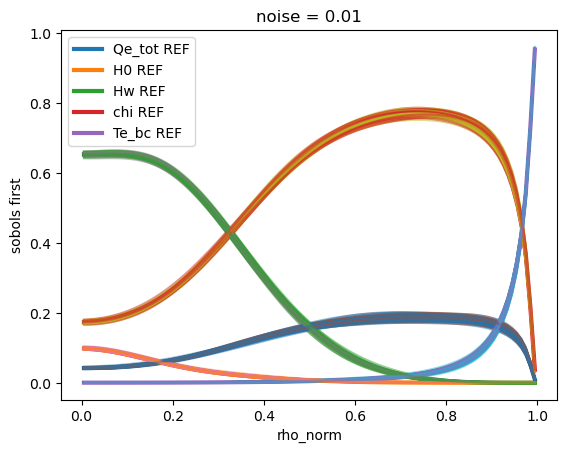

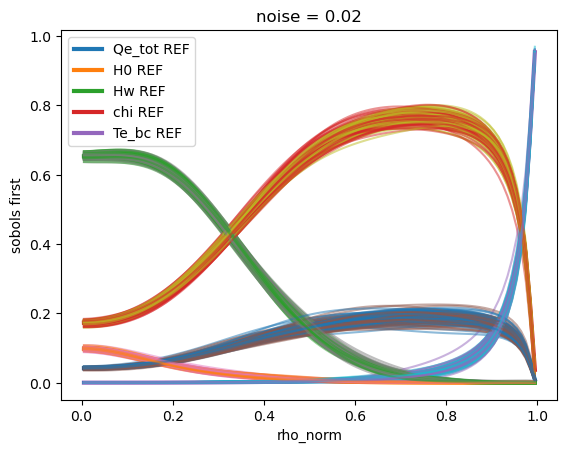

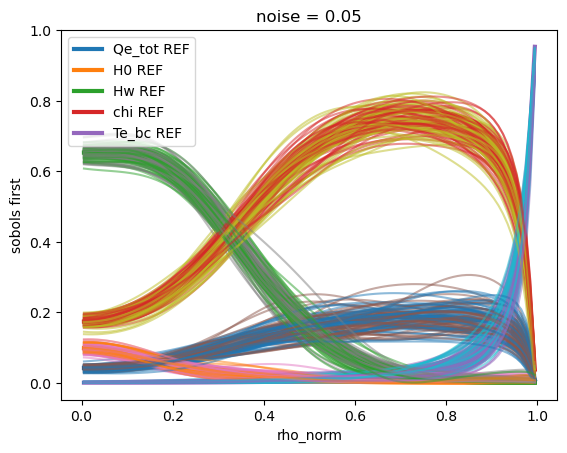

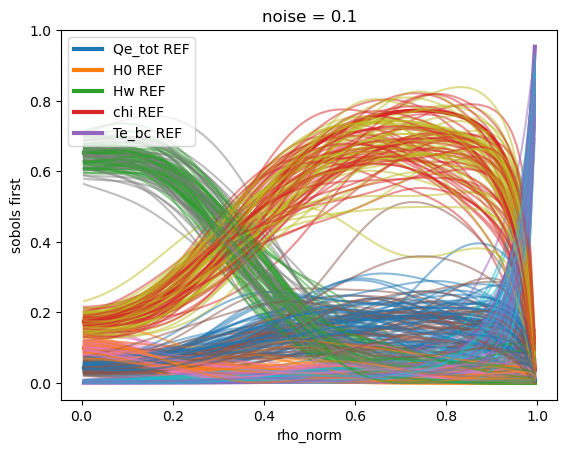

In [19]:
# Plot all of the samples, together with the reference values
for noise in collect_results.keys():
  plt.figure()
  for s in results.sobols_first('te').keys():
    plt.plot(rho_norm, results.sobols_first('te')[s], '-', lw=3, label=f'{s} REF')
  for c in collect_results[noise]:
    for s in results.sobols_first('te').keys():
      plt.plot(rho_norm, c['R'].sobols_first('te')[s], alpha=0.5)
  plt.xlabel('rho_norm')
  plt.ylabel('sobols first')
  plt.title(f'{noise = }')
  plt.legend(loc=0)

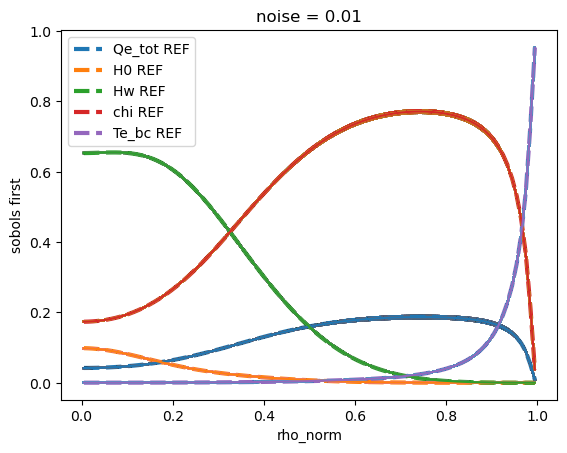

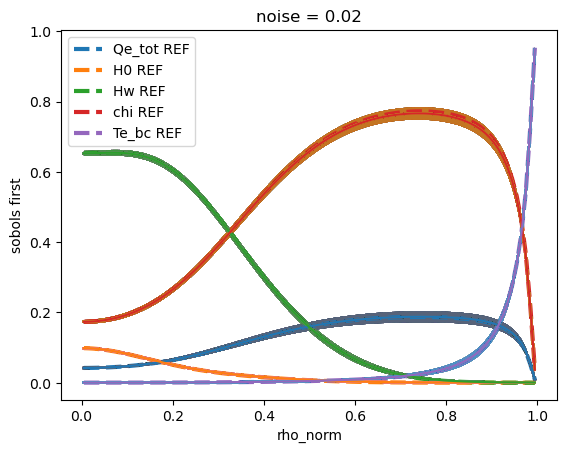

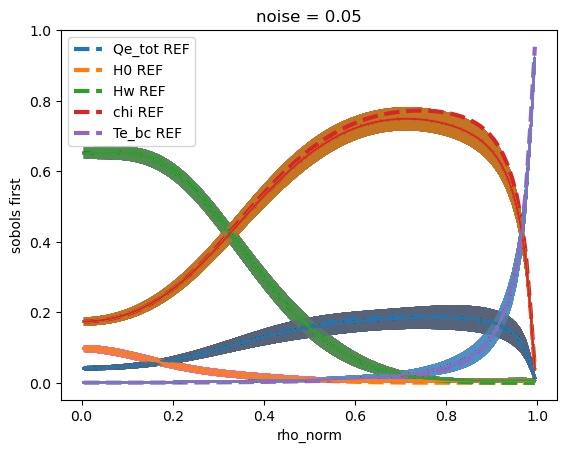

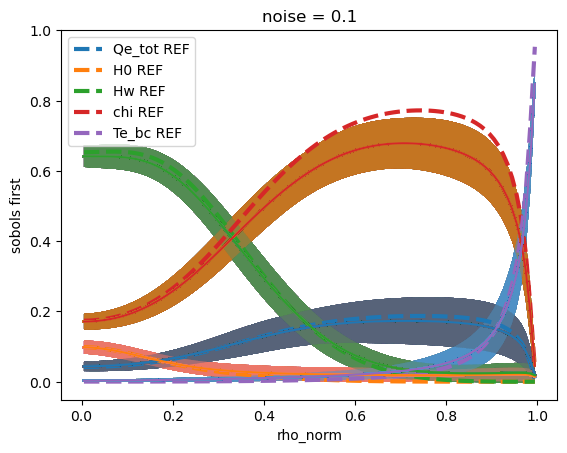

In [20]:
# Plot the mean and standard deviation of the perturbed results, together with the original value
for noise in collect_results.keys():
  plt.figure()
  for s in results.sobols_first('te').keys():
    plt.plot(rho_norm, results.sobols_first('te')[s], '--', lw=3, label=f'{s} REF')
  for c in collect_results[noise]:
    for s in results.sobols_first('te').keys():
      V = np.array([c['R'].sobols_first('te')[s] for c in collect_results[noise]])
      plt.plot(rho_norm, V.mean(axis=0), '-')
      plt.fill_between(rho_norm, V.mean(axis=0) - V.std(axis=0), V.mean(axis=0) + V.std(axis=0), alpha=0.1)
  plt.xlabel('rho_norm')
  plt.ylabel('sobols first')
  plt.title(f'{noise = }')
  plt.legend(loc=0)

At higher levels of noise we see that the Sobol first values for H0 drop, particularly in the range 0.5 -- 0.9